### LSTM per serie dati multivariata. Previsione 1 Step

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])
cell_1 = agg_by_cell.get_group('486-1252')
cell_2 = agg_by_cell.get_group('486-1256')
cell_3 = agg_by_cell.get_group('486-1258')
# define input sequence
series1 = cell_1['nr_people'].values
series2 = cell_2['nr_people'].values
series3 = cell_3['nr_people'].values
print(type(series2))

Using TensorFlow backend.


<class 'numpy.ndarray'>


In [2]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))])

# convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3,  out_seq))

# choose a number of time steps
n_steps = 4

# convert into input/output
X, y = split_sequences(dataset, n_steps)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

### Dividi in Train-validation-test

In [3]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
print(len(train_X), len(train_y), len(test_X), len(test_y), len(val_X), len(val_y))

5783 5783 3542 3542 2479 2479


### Modello LSTM 

In [4]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu')) 
model.add(Dense(n_features)) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=2)

Epoch 1/50
 - 3s - loss: 168.8400
Epoch 2/50
 - 2s - loss: 9.3534
Epoch 3/50
 - 2s - loss: 8.4023
Epoch 4/50
 - 2s - loss: 7.3226
Epoch 5/50
 - 2s - loss: 7.1381
Epoch 6/50
 - 2s - loss: 7.5172
Epoch 7/50
 - 2s - loss: 6.7537
Epoch 8/50
 - 2s - loss: 7.1109
Epoch 9/50
 - 2s - loss: 7.2964
Epoch 10/50
 - 2s - loss: 6.7812
Epoch 11/50
 - 2s - loss: 6.5884
Epoch 12/50
 - 2s - loss: 7.1204
Epoch 13/50
 - 2s - loss: 6.8718
Epoch 14/50
 - 2s - loss: 7.0477
Epoch 15/50
 - 2s - loss: 6.3087
Epoch 16/50
 - 2s - loss: 6.8599
Epoch 17/50
 - 3s - loss: 6.6807
Epoch 18/50
 - 2s - loss: 6.2846
Epoch 19/50
 - 2s - loss: 6.4373
Epoch 20/50
 - 2s - loss: 6.4921
Epoch 21/50
 - 2s - loss: 6.3193
Epoch 22/50
 - 2s - loss: 6.3182
Epoch 23/50
 - 2s - loss: 6.4883
Epoch 24/50
 - 2s - loss: 6.8509
Epoch 25/50
 - 2s - loss: 6.5553
Epoch 26/50
 - 3s - loss: 6.0281
Epoch 27/50
 - 2s - loss: 6.1198
Epoch 28/50
 - 2s - loss: 6.4074
Epoch 29/50
 - 2s - loss: 6.4606
Epoch 30/50
 - 2s - loss: 6.0197
Epoch 31/50
 - 3s

### Dimostra previsone

In [6]:
x_input = np.array([[ 36,  43,  42, 121],
                    [ 34,  40,  40, 114],
                    [ 33,  39,  39, 111],
                    [ 32,  37,  37, 106]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=2)
print(yhat)

[[ 30.507952  36.146732  36.36125  103.0378  ]]


### Calcolo dell'errore

In [7]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y
expected = np.reshape(expected, predicted.shape[0])
print(len(expected))
print(len(predicted))

#expected = np.reshape(expected, expected.shape[0] * expected.shape[1]* expected.shape[2])

14168
14168


### Grafico distribuzione errore

Mean Absolute Error =  1.4548494083473469


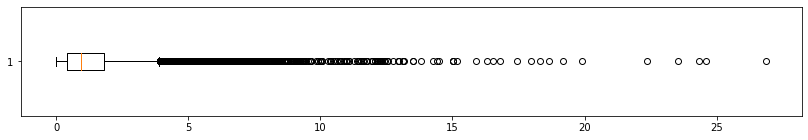

In [8]:
# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()